# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import kaggledatasets 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from glob import glob
from os.path import join
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from sklearn.model_selection import ParameterGrid
from scikeras.wrappers import KerasClassifier 
from sklearn.model_selection import RandomizedSearchCV

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


gpus = tf.config.list_physical_devices('GPU')                       #se the gpu
if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    
print(tf.__version__)


Number of replicas: 1
2.14.0


In [2]:

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [128, 128]
#EPOCHS = 15

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.

In [5]:
# split and save dataset into train/val and test data
dataset_path = 'Dataset'
test_size=0.2
train_path = dataset_path+'/train' #folder doesn’t exist yet
test_path= dataset_path+'/test'
classes = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
print(classes)

if os.path.isdir(train_path):
    print('Dataset has already been splited and saved into train/val and test data.')
else:
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    print(classes)

    for class_name in classes:
        print(class_name)
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        # Get the list of files in the class
        files = os.listdir(class_path)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Divide the class dataset into training and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Save the training files to the training folder
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(train_path, class_name, file)
            shutil.copy(src_path, dst_path)

        # Save the test files to the test folder
        for file in test_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(test_path, class_name, file)
            shutil.copy(src_path, dst_path)

trainval_cnt = sum([len(files) for _, _, files in os.walk(train_path)])
test_cnt = sum([len(files) for _, _, files in os.walk(test_path)]) # might use this in case of using different batch size for test set
validation_split = 0.2
BATCH_SIZE = round(trainval_cnt * validation_split * 0.1)
print("Batch Size for train and val set:", BATCH_SIZE)

# split train/val into train and val data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Dataset has already been splited and saved into train/val and test data.
Batch Size for train and val set: 102
Found 5119 files belonging to 4 classes.
Using 4096 files for training.
Found 5119 files belonging to 4 classes.
Using 1023 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [8]:

train_ds.class_names = classes
val_ds.class_name = classes

NUM_CLASSES = len(classes)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

Mild_Demented class has 716 samples
Moderate_Demented class has 51 samples
Non_Demented class has 2560 samples
Very_Mild_Demented class has 1792 samples


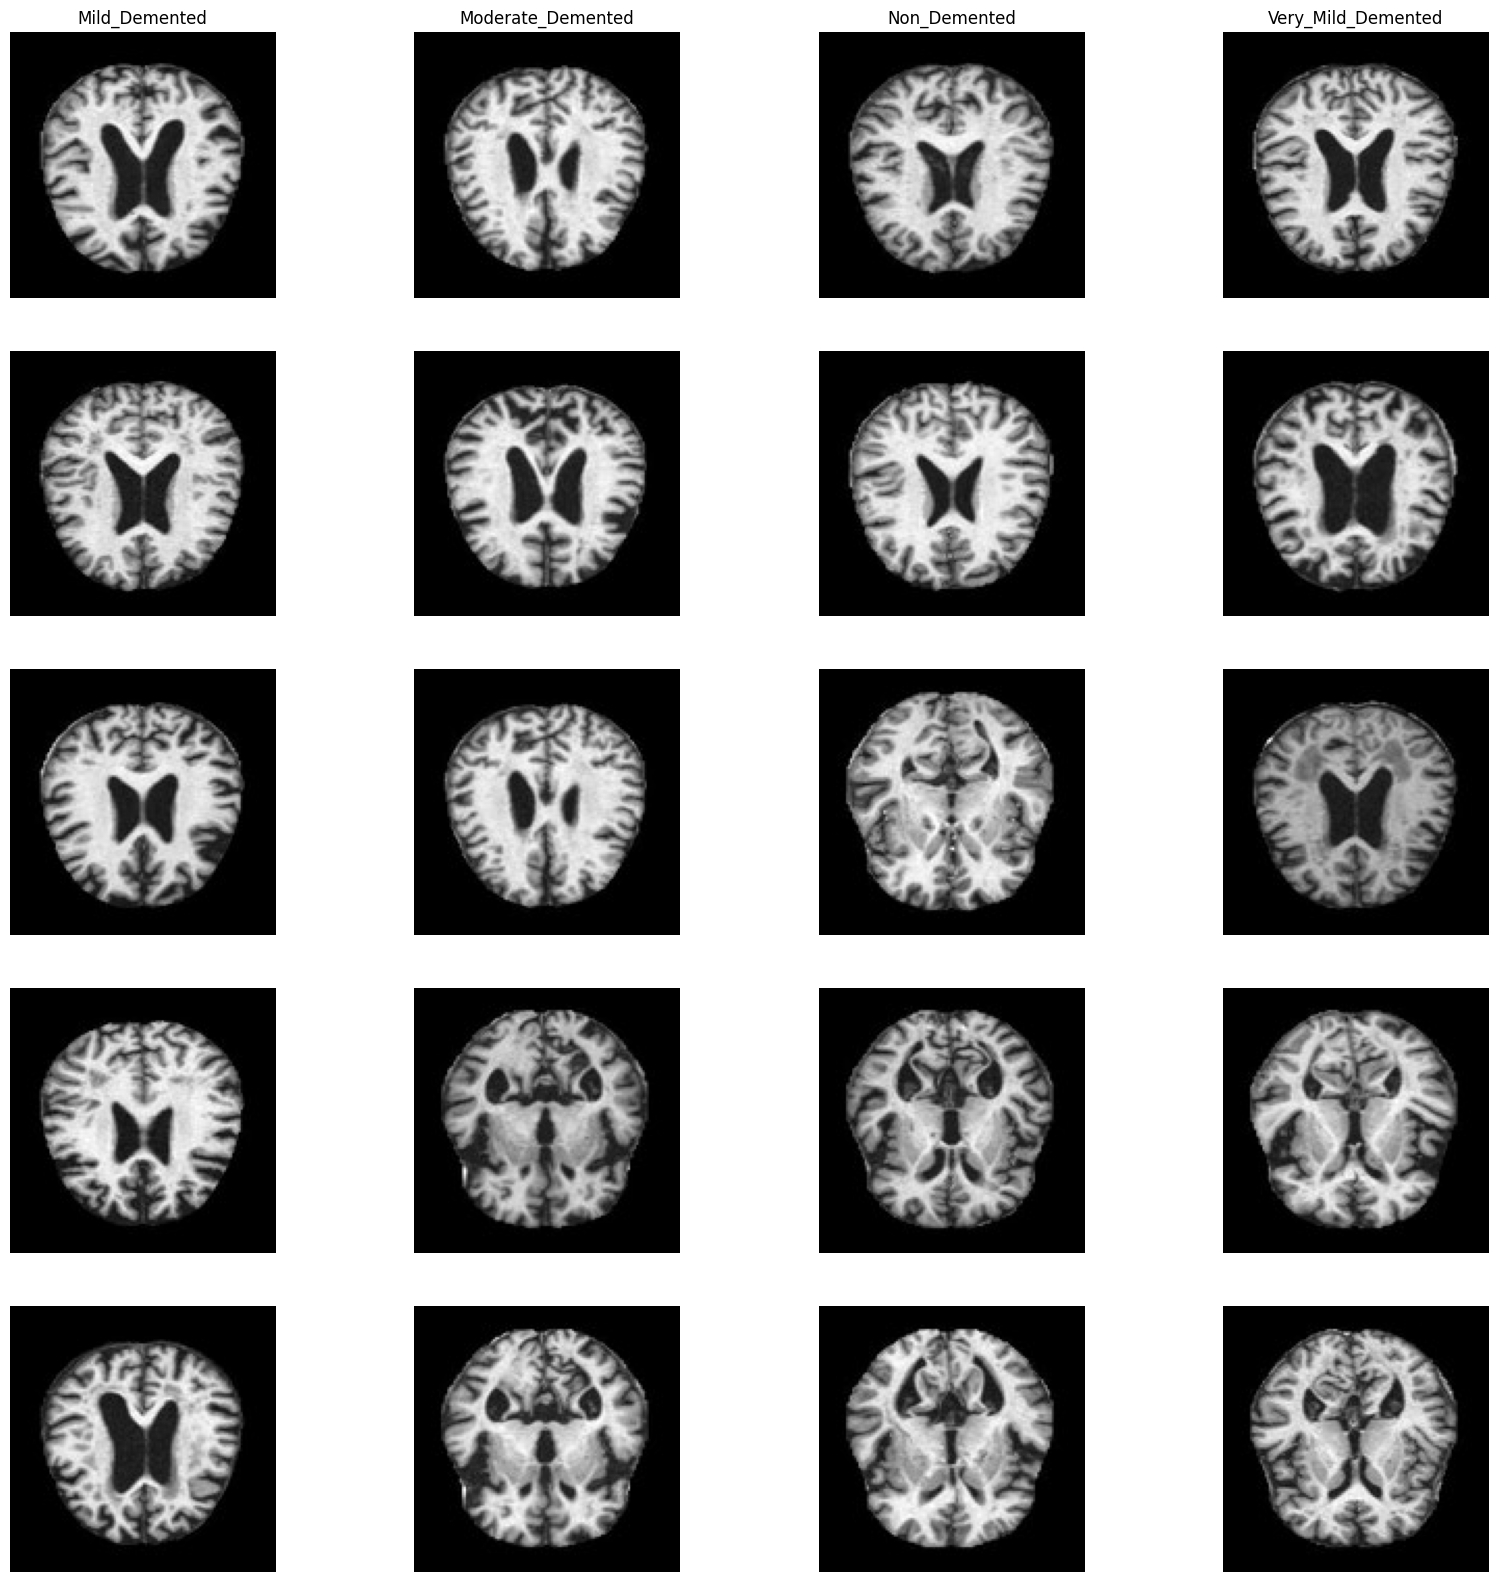

In [16]:
# let's create a dictionary where:
# - keys are folder names (-> the 8 classes)
# - values are the filenames for the files in each folder
imgs = {c: glob(join(train_path, c, "*")) for c in classes}

for key in imgs.keys():
   print("{} class has {} samples".format(key,len(imgs[key])))

nrows=5

# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES

fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i,(c,fnames) in enumerate(imgs.items()): # i is the count, (images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname=(fnames[n]).replace('\\','/')
        im= Image.open(fname)
        gray_im = im.convert('L')
        axs[n,i].imshow(gray_im, cmap='gray')
for ax in axs.flatten():
    ax.axis("off")

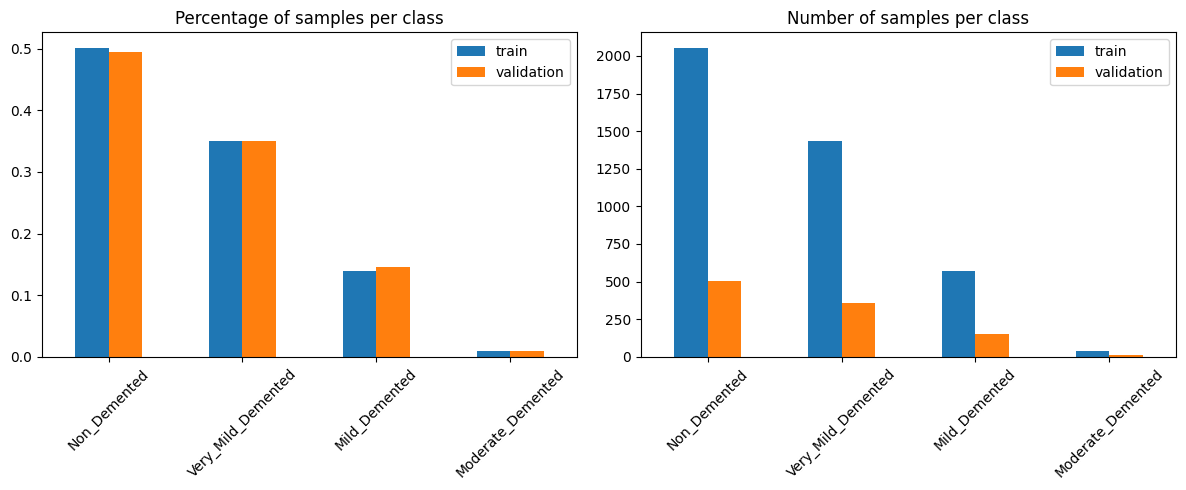

<Figure size 640x480 with 0 Axes>

In [9]:
train_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_labels = np.concatenate([y for _, y in val_ds], axis=0)
train_labels = [train_ds.class_names[idx] for idx in train_labels]
val_labels = [val_ds.class_names[idx] for idx in val_labels]

fig,axs = plt.subplots(1,2,figsize=(12,5))

vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[0], title=vis_title, rot=45)
axs[0].legend(['train', 'validation'])

plt.subplot(1,2,2)
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[1], title=vis_title, rot=45)
axs[1].legend(['train', 'validation'])

plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('Dataset distribution.png')

Is possible to see how the dataset is unbalanced, is usefull to apply data aumentation in a specific manner for each class in order to prevent understimation of the minority class.

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [10]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [11]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
def labels_fromPrefetch(test_ds):
    #  Function to extract labels from a Prefetch Dataset 
    # Get y_true labels
    test_ds_it=test_ds.as_numpy_iterator() #Numpy iterator
    true_labels = []  # Lista per le etichette reali

    for batch in test_ds_it:
        # Assumiamo che ogni batch contenga etichette reali e previste
        true_batch,true_batch_labels = batch  # Sostituisci con la chiave corretta
        # Aggiungere le etichette del batch alle liste
        true_labels.extend(true_batch_labels)


    # Confusion matrix
    y_true_onehot = np.vstack(true_labels)
    y_true=np.argmax(y_true_onehot,axis=1)
    return y_true

def observations_fromPrefetch(train_ds):
    iterator = iter(train_ds)
    all_tensors=[]
    while True:
        try:
            batch_x, batch_y = iterator.get_next()
            all_tensors.append((batch_x))
        except tf.errors.OutOfRangeError:
            # Fine del dataset
            break
    return all_tensors

In [21]:
## Layers for data augmentation

RandomZoom_layer1=(tf.keras.layers.RandomZoom(
    height_factor=(0.1, 0.3),
    width_factor=(0.1, 0.3),
    fill_mode="constant",
    seed=2023
))

RandomWidth_layer1=tf.keras.layers.RandomWidth(
    (-0.2,0.2), interpolation='bilinear', seed=2023) 

RandomHeight_layer1=tf.keras.layers.RandomHeight(
    (-0.2,0.2), interpolation='bilinear', seed=2023) 

RandomRotation_layer1=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomRotation_layer2=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear', fill_value=0.0,
    seed=2023)

RandomFlip_layer1=tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2023)


RandomTranslation_layer1=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomTranslation_layer2=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023,fill_value=0.0)

RandomCrop_layer1=tf.keras.layers.RandomCrop(
    120,120, seed=2023)

RandomBrightness_layer1=tf.keras.layers.RandomBrightness(
    0.2, seed=2023)

RandomContrast_layer1=tf.keras.layers.RandomContrast(
    0.2 , seed=2023)
input_layer= tf.keras.Input(shape=(*IMAGE_SIZE, 3))

In [13]:
import random
print(random.random())

0.27026419676266167


In [23]:
# DATA AUGMENTATION FOR BALANCING CLASSES

#Class - 1: Mild Demented (896 images)
#Class - 2: Moderate Demented (64 images)
#Class - 3: Non Demented (3200 images)
#Class - 4: Very Mild Demented (2240 images)
#EXTRACT LABELS
labels_train=labels_fromPrefetch(train_ds)   #1d array of dimension (4095)       
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> 3,6 (=4) data aug
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> 50 data aug
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> 0 data aug
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1,43 (=1) data aug


# EXTRACT OBSERVATIONS 
tensors_train=observations_fromPrefetch(train_ds)  #list of 103 4D tensorflows tensors (40,128,128,3): 

list_of_arrays = [tensor.numpy() for tensor in tensors_train]  #list of 103 4D arrays  (40,128,128,3)
s=list_of_arrays[0].shape  # (40,128,128,3)
images_tot = [np.reshape((tensor), (-1, 128, 128, 3)) for tensor in list_of_arrays]  # 4D array (4095,128,128,3) 
images_tot = list(np.concatenate(images_tot, axis=0))  # list of 4095 3d arrays
example=images_tot[0]   #3darray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]

augmented_images = []
augmented_labels = []
for i in range(len(images_tot)): #len is 4095, first dimensions
    image = images_tot[i]   #nd array (128,128,3)
    label = labels_train[i]

     # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented--> 2053/568= 3,6 (=4) data aug
        augmented_image = RandomRotation_layer1(image)  #tensor 
        augmented_image2= RandomTranslation_layer1(image)
        #augmented_image3=RandomZoom_layer1(image)                                    
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2])            
    if label == 1: #41 Class  2: Moderate Demented --> 2053/41= 50 data aug
       augmented_image_list = [RandomRotation_layer1(image) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [RandomTranslation_layer1(image) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)
       augmented_images_conc2=augmented_images_conc2[128:]

       #for augmented_image in augmented_image2_list:
    
       augmented_image3_list = [RandomZoom_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image3_list:
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)
       augmented_images_conc3=augmented_images_conc3[128:]

       augmented_image4_list = [RandomFlip_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image4_list:
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       augmented_images_conc4=augmented_images_conc4[128:]

       augmented_image5_list = [RandomBrightness_layer1(image)  for _ in range(10)] ### I DON'T KNOW IF BRIGHTNESS WORKS!
       #for augmented_image in augmented_image5_list:
       #augmented_image_conc5 = tf.concat([image] + augmented_image5_list, axis=0)
       #augmented_images_conc5=augmented_image_conc5[128:]
       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4], axis=0)
       # ADD IMAGE!!
    if label == 2: #2053 Class 3: Non Demented --> 2053/2053=1 data aug
       augmented_image=image
       augmented_images_conc=augmented_image
        #augmented_images_conc =augmented_image
    if (label == 3) : 
        if (random.random()<0.3) :  #1433 Class 4: Very Mild Demented --> 2053/1433 = 1,43 (=2) data aug
            augmented_image=RandomRotation_layer1(image)
            augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image]) 
        else:
            augmented_image=image
            augmented_images_conc=augmented_image
        

    #Target Shape of tensor
    target_shape = (128, 128, 3)

    # Calculate the number of tensors to be created
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)

    for el in augmented_images_resh:
       augmented_images.append(el)
    for i in range(len(augmented_images_resh)):
       augmented_labels.append(label)


In [25]:
#function that let us to prefetch the augmented dataset
def Prefetch_fromLO(test_labels,test_observations,batch_size=BATCH_SIZE):
    test_labels_np = np.array(test_labels)
    test_observations_np = np.array(test_observations)

    # Create a tf.data.Dataset from the list
    dataset = tf.data.Dataset.from_tensor_slices((test_observations_np,  test_labels_np))
    
    # Apply prefetching
    prefetch_dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Apply any additional transformations or mappings here
    # For example, if you want to one-hot encode the labels, you can use map:
    prefetch_dataset = prefetch_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)
    prefetch_dataset= prefetch_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Batch the dataset
    prefetch_dataset = prefetch_dataset.batch(batch_size)

    return prefetch_dataset

In [26]:
train_ds_aug=Prefetch_fromLO(augmented_labels,augmented_images)

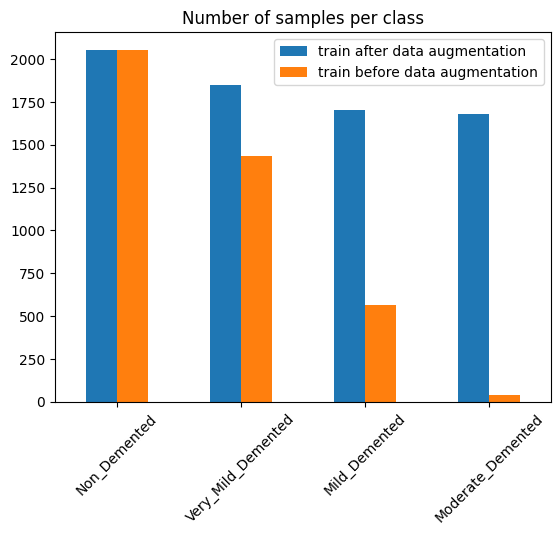

In [27]:
train_labels_names=['Mild_Demented' if el==0 else 'Moderate_Demented' if el==1 else 'Non_Demented'  if el==2 else 'Very_Mild_Demented'   for el in augmented_labels]
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels_names).value_counts(normalize=vis_ratio), pd.Series(train_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', title=vis_title, rot=45)
plt.legend(['train after data augmentation', 'train before data augmentation'])
plt.savefig('Data augmentation results.png')

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [28]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate, L2): # add regularization at the dense layer (dense layer has are more or less fulliconnected, is important to reguraraze weight in order to avoid overfitting)
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        tf.keras.layers.BatchNormalization(), #change the layer: is not practice use a batch normalization after a relu activation
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model_original():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7, 0),
        dense_block(128, 0.5, 0),
        dense_block(64, 0.2, 0),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

def build_model_tunable(L2,drop_out):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(drop_out),
        
        conv_block(256),
        tf.keras.layers.Dropout(drop_out),
        
        tf.keras.layers.Flatten(),
        dense_block(512, drop_out*3, L2),
        dense_block(128, drop_out*2, L2),
        dense_block(64, drop_out, L2),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [ ]:
#tf.keras.utils.plot_model(model, to_file="cnn.png", show_shapes=True) #plot the network

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [29]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1281 files belonging to 4 classes.


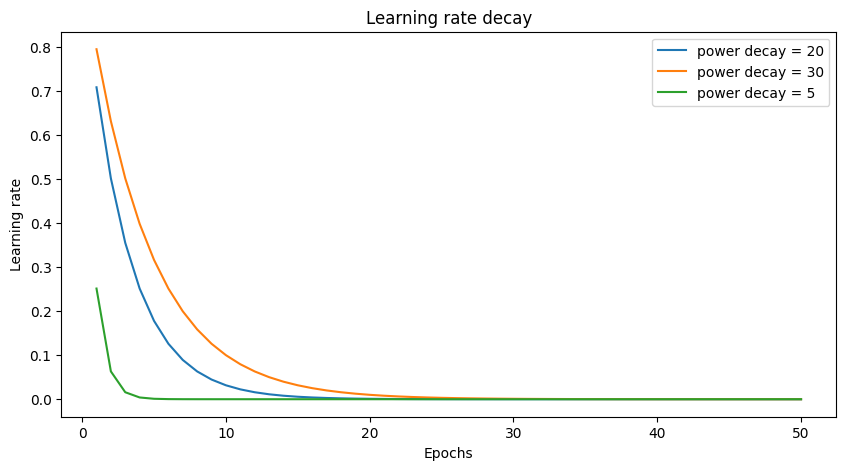

In [14]:
def exponential_decay(s):
    def exponential_decay_fn(epoch):
        return 0.001 **(epoch / s)
    return exponential_decay_fn

epochs=np.linspace(1,50,50)
lr_epochs=0.001**(epochs / 20)
lr_epochs2=0.001**(epochs/30)
lr_epochs3=0.001**(epochs / 5)

plt.figure(figsize=(10,5))
plt.plot(epochs, lr_epochs,label="power decay = 20")
plt.plot(epochs, lr_epochs2,label="power decay = 30")
plt.plot(epochs, lr_epochs3,label="power decay = 5")

plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()

plt.savefig('Learning_Rate_Decay.png')

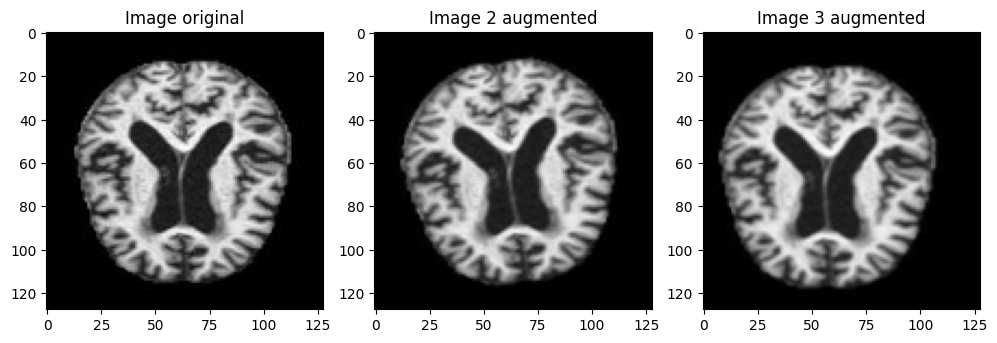

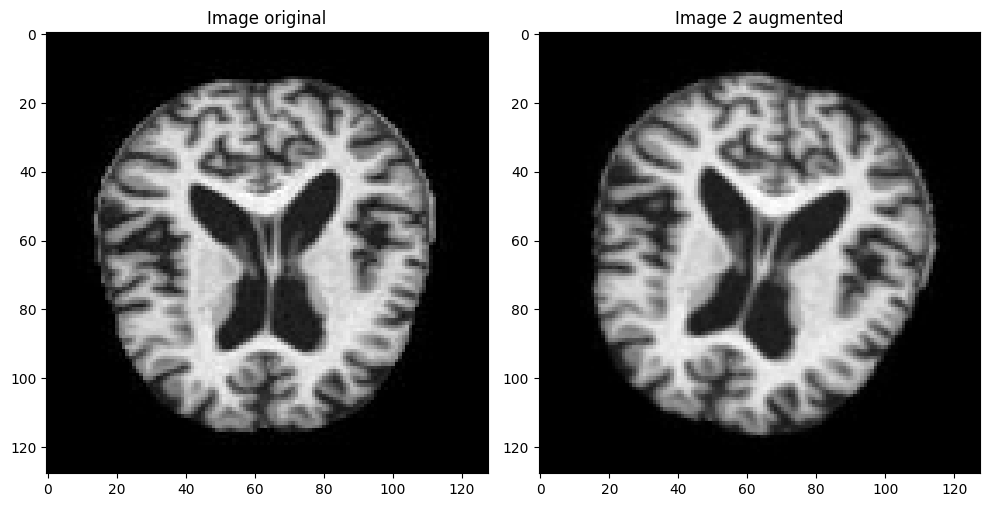

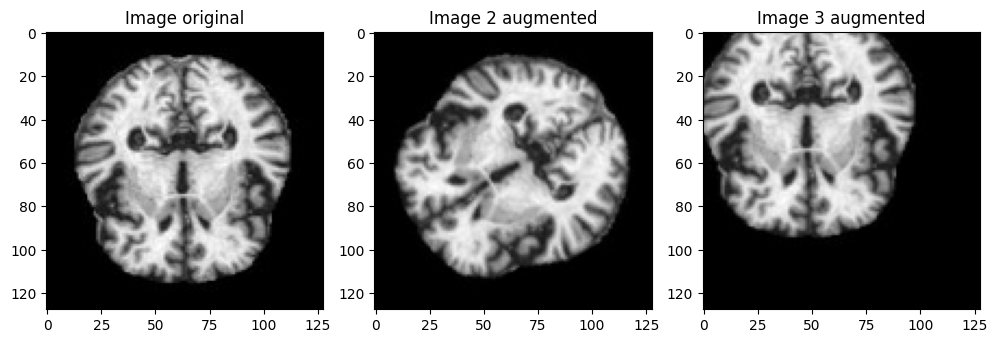

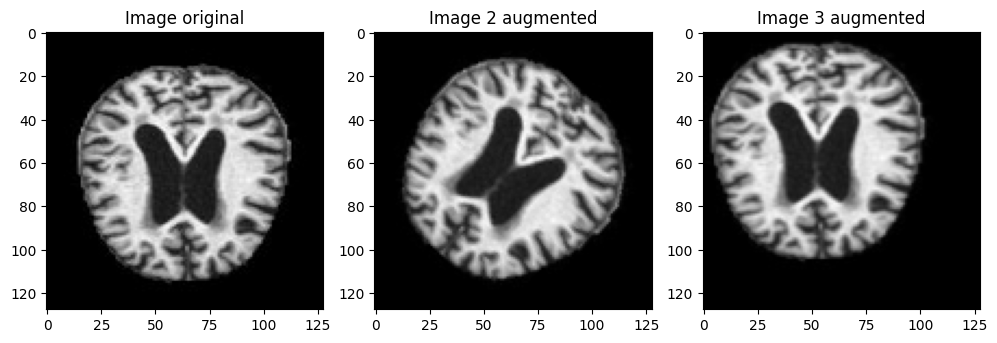

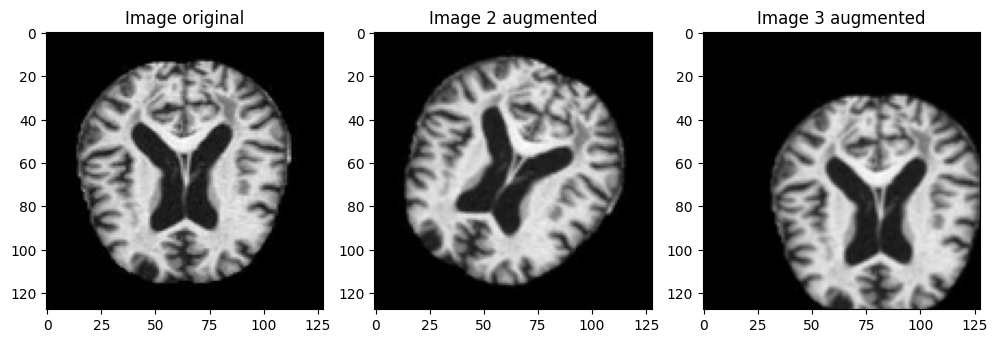

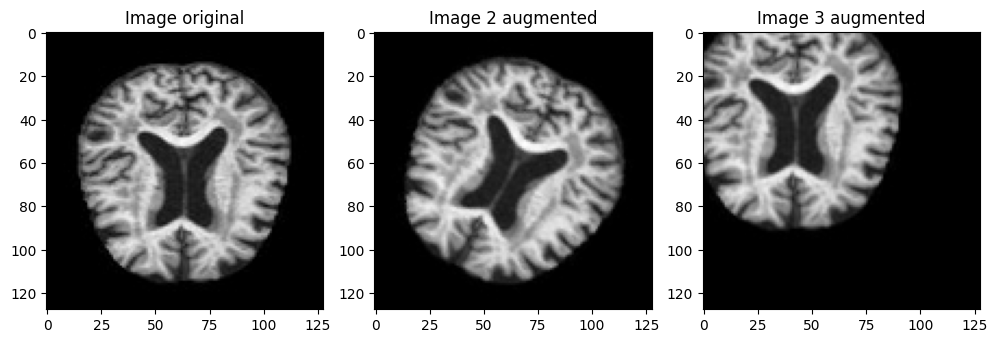

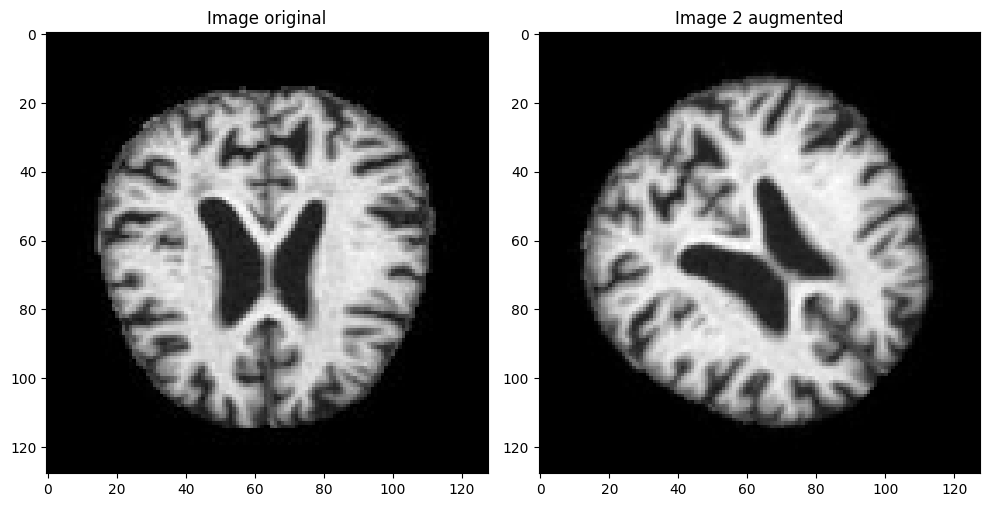

NameError: name 'class_names' is not defined

In [18]:
RandomZoom_layer1=(tf.keras.layers.RandomZoom(
    height_factor=(-0.1, -0.3),
    width_factor=(-0.1, -0.3),
    fill_mode="constant",
    seed=2023
))

RandomRotation_layer1=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023)

RandomFlip_layer1=tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2023)

RandomTranslation_layer1=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023)

RandomBrightness_layer1=tf.keras.layers.RandomBrightness(
    0.2, seed=2023)


#---------------------------------------


def save_augmented_image(image,i,label,folderto,transf=""):
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  filename = f"image_{i}_label_{label}_{transf}.jpg"  # Use a counter or other identifiers        # Create a unique filename or use some identifier based on your datase
  image_path = os.path.join(folderto, filename).replace("\\","/")  # Specify the complete path for saving the image
  tf.keras.preprocessing.image.save_img(image_path, image_array)          # Save the image using a suitable library like PIL or OpenCV

def rescale_im(im):
  min_value = np.min(im)
  max_value = np.max(im)
  scaled_im = (im - min_value) / (max_value - min_value)
  return scaled_im
#-----------------------------------------------


# DATA AUGMENTATION FOR BALANCING CLASSES AND RESCALING!

#Class - 1: Mild Demented (896 images)
#Class - 2: Moderate Demented (64 images)
#Class - 3: Non Demented (3200 images)
#Class - 4: Very Mild Demented (2240 images)

#EXTRACT LABELS
import random
labels_train=labels_fromPrefetch(train_ds)   #1d array of dimension (4095)       
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> 3,6 (=4) data aug
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> 50 data aug
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> 0 data aug
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1,43 (=1) data aug


# EXTRACT OBSERVATIONS 
tensors_train=observations_fromPrefetch(train_ds)  #list of 41 4D tensorflows tensors (102,128,128,3): 

list_of_arrays = [tensor.numpy() for tensor in tensors_train]  #list of 41 4D arrays  (102,128,128,3)
s=list_of_arrays[0].shape  # (102,128,128,3)

images_tot = [np.reshape((tensor), (-1, 128, 128, 3)) for tensor in list_of_arrays]  # 4D array (4095,128,128,3) 
images_tot = list(np.concatenate(images_tot, axis=0))  # list of 4095 3d arrays

example=images_tot[0]   #3darray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]


augmented_images = []
augmented_labels = []
folder_augmented_0=r"C:/Users/Giacomo Gumierato/Desktop/unipd/anno 5/deeplearning/deeplearningProject/Deep-Learning-project/Augmented_TrainDataset/MildDemented"
folder_augmented_1=r"C:/Users/Giacomo Gumierato/Desktop/unipd/anno 5/deeplearning/deeplearningProject/Deep-Learning-project/Augmented_TrainDataset/ModerateDemented"
folder_augmented_2=r"C:/Users/Giacomo Gumierato/Desktop/unipd/anno 5/deeplearning/deeplearningProject/Deep-Learning-project/Augmented_TrainDataset/NonDemented"
folder_augmented_3=r"C:/Users/Giacomo Gumierato/Desktop/unipd/anno 5/deeplearning/deeplearningProject/Deep-Learning-project/Augmented_TrainDataset/VeryMildDemented"
folders_augmented=[folder_augmented_0,folder_augmented_1,folder_augmented_2,folder_augmented_3]
for f in folders_augmented:
 if not os.path.exists(f):
        os.makedirs(f)
 [os.unlink(os.path.join(f, file)) for file in os.listdir(f) if os.path.isfile(os.path.join(f, file))]


# SHOW FOR THE FIRST 12 ITERATIONS, ONE IMAGE AND ITS AUGMENTED

 # Delete files augmented previously, if  present
for i in range(len(images_tot)): #len is 4095, first dimensions
    image = rescale_im(images_tot[i])  #nd array (128,128,3)   # RESCALE 0-1
    label = labels_train[i]
    # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented--> 2053/568= 3,6 (=4) data aug
        augmented_image = rescale_im(RandomRotation_layer1(image)) #tensor 
        augmented_image2= rescale_im(RandomTranslation_layer1(image) )                                       
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2])    
        
        # SAVE image and augmented ones
        save_augmented_image(image,i,label,folder_augmented_0)
        save_augmented_image(augmented_image,i,label,folder_augmented_0,transf="RandRot")
        save_augmented_image(augmented_image2,i,label,folder_augmented_0,transf="RandTrasl")
    if label == 1: #41 Class  2: Moderate Demented --> 2053/41= 50 data aug
       augmented_image_list = [rescale_im(RandomRotation_layer1(image)) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [rescale_im(RandomTranslation_layer1(image)) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)
       augmented_images_conc2=augmented_images_conc2[128:]

    
       augmented_image3_list = [rescale_im(RandomZoom_layer1(image))  for _ in range(10)]
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)
       augmented_images_conc3=augmented_images_conc3[128:]

       augmented_image4_list = [rescale_im(RandomFlip_layer1(image))  for _ in range(10)]
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       augmented_images_conc4=augmented_images_conc4[128:]


       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4], axis=0)
       n=0

       # SAVE IMAGE  +
       save_augmented_image(image,i,label,folder_augmented_1,transf="RandRot"+str(n))
       n=1
       for im in augmented_image_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandRot"+str(n))
         n+=1
       n=1
       for im in augmented_image2_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandTrasl"+str(n))
         n+=1
       n=1
       for im in augmented_image3_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandZoom"+str(n))     
         n+=1
       n=1
       for im in augmented_image4_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandFlip"+str(n))  
         n+=1
    if label == 2: #2053 Class 3: Non Demented --> 2053/2053=1 data aug
       augmented_image=image  #rescaled
       augmented_images_conc=augmented_image
       save_augmented_image(augmented_image,i,label,folder_augmented_2)
    if label == 3: 
        if (random.random()<0.3) :  #1433 Class 4: Very Mild Demented --> 2053/1433 = 1,43 (=2) data aug
            augmented_image=rescale_im(RandomRotation_layer1(image))
            augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image]) 
            save_augmented_image(image,i,label,folder_augmented_3)
            save_augmented_image(augmented_image,i,label,folder_augmented_3,transf="RandRot")
        else:
            augmented_image=image  #rescaled
            augmented_images_conc=augmented_image
            save_augmented_image(augmented_image,i,label,folder_augmented_3)
       
    #Target Shape of tensor
    target_shape = (128, 128, 3)

    # Calculate the number of tensors to be created
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)
    if i<=20 and num_tensors!=1:  #augmented_images_conc contains the original image and the augmented ones
      fig, axs = plt.subplots(nrows=1, ncols=num_tensors, figsize=(10, 10))
      for k in range(num_tensors):
        imtoshow=(augmented_images_resh[k]).numpy()
        #imtoshow=rescale_im(imtoshow) #values 0-1
        axs[k].imshow(imtoshow)  # Replace with your actual image plotting code
        if k==0:
           axs[k].set_title(f"Image original")
        else:
          axs[k].set_title(f"Image {k + 1} augmented")
        # Add a list below each image
        #axs[k].text(0.5, -0.15, '\n'.join(imtoshow), transform=axes[i].transAxes, ha='center', va='top')   
      # Adjust layout for better spacing
      plt.tight_layout()
      # Show the plot
      plt.show()

    for el in augmented_images_resh:
       augmented_images.append(el)
    for ss in range(len(augmented_images_resh)):
       augmented_labels.append(label)



#----------------------------------


number_of02=augmented_labels.count(0)  #568= Class 1 : Mild Demented-->  1704 Mild Demented
number_of12=augmented_labels.count(1)  #41= Class  2: Moderate Demented (64 images)-->1681 Moderate Demented
number_of22=augmented_labels.count(2)  #2053= Class 3: Non Demented (3200 images)--> 2053  Non Demented
number_of32=augmented_labels.count(3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1860 Very Mild Demented

NUM_IMAGES_POST = []



In [20]:
class_names=('MildDemented','ModerateDemented','NonDemented','VeryMildDemented')
for label in class_names:
    dir_name_augmented= r"C:/Users/Giacomo Gumierato/Desktop/unipd/anno 5/deeplearning/deeplearningProject/Deep-Learning-project/Augmented_TrainDataset/"+label+"/"
    num=len([name for name in os.listdir(dir_name_augmented)])
    print("{} class has {} samples in training set, after data augmentation".format(label,num))
    NUM_IMAGES_POST.append(num)

NUM_IMAGES_POST

MildDemented class has 1701 samples in training set, after data augmentation
ModerateDemented class has 1681 samples in training set, after data augmentation
NonDemented class has 2054 samples in training set, after data augmentation
VeryMildDemented class has 1862 samples in training set, after data augmentation


[1701, 1681, 2054, 1862]

In [57]:
#IMPORTING ALEXNET
alexnet = models.alexnet(weights='AlexNet_Weights.DEFAULT')
#for param in alexnet.features.parameters():
    #param.requires_grad = False
#freeze the convolutional layers
from torch.optim.lr_scheduler import ExponentialLR
 
alexnet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.001)

In [60]:

all_predictions = []
all_labels = []
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # I preferred to resize the images, cause i think it's more difficult to change a layer
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # ImageNet normalization
])
train_dataset=ImageFolder("Augmented_TrainDataset", transform=transform)
train_dataloader= DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = ImageFolder("Dataset/test", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
num_epochs =1
#for param in alexnet.features[:6].parameters():
    #param.requires_grad = True
#unfreeze the 6th layer
for epoch in range(num_epochs):
    for inputs, labels in train_dataloader:
        
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()#update lr
        

alexnet.eval()

with torch.no_grad():  # Disable gradient computation during inference
    for inputs, labels in test_dataloader:
        outputs = alexnet(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')#ACCURACY IS SHIT
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Stampa la confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calcola e stampa il report di classificazione
class_names = [str(i) for i in range(len(conf_matrix))]
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Test Accuracy: 34.11%
Confusion Matrix:
[[ 82   0  73  25]
 [  4   0   7   2]
 [166   0 267 207]
 [159   0 201  88]]

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.46      0.28       180
           1       0.00      0.00      0.00        13
           2       0.49      0.42      0.45       640
           3       0.27      0.20      0.23       448

    accuracy                           0.34      1281
   macro avg       0.24      0.27      0.24      1281
weighted avg       0.37      0.34      0.34      1281



C:\Users\Giacomo Gumierato\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Giacomo Gumierato\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Giacomo Gumierato\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skl

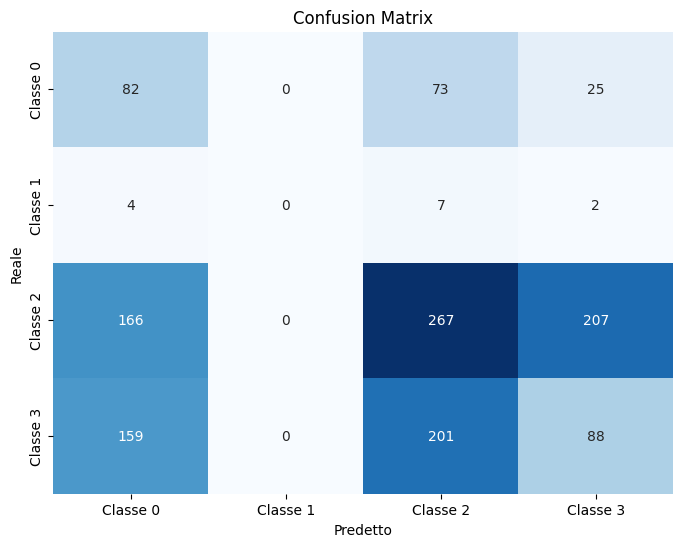

In [59]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1','Classe 2','Classe 3'], yticklabels=['Classe 0', 'Classe 1','Classe 2','Classe 3'])
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix')
plt.show()

Let's fit our model!

In [ ]:
# ORIGINAL MODEL WITH ORIGINAL DATA
model_name = 'Original_model.h5'
EPOCHS = 100

with strategy.scope():
    model = build_model_original()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
        
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)         
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

In [ ]:
# ORIGINAL MODEL WITH AUGMENTED DATA
model_name = 'Original_model_augmented_data.h5'
EPOCHS = 100

with strategy.scope():
    model = build_model_original()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
        
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)         
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original_AUG = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds_aug,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

In [ ]:
#Hyperparameter tuning with augmented data
'''
drop_out = [0.1, 0.2, 0.3]
s = [5, 20, 30]
L2 = [1e-4, 1e-3, 1e-2]
'''
drop_out = [0.1]
s = [20]
L2 = [1e-3]

EPOCHS = 40

hparam = {
    'drop_out' : drop_out,
    's' : s,
    'L2' : L2
}

hparam_grid = ParameterGrid(hparam)

history = dict()

for p in hparam_grid:
    drop_out = p['drop_out']
    s = p['s']
    L2 = p['L2']

    model_name = 's_'+str(s)+'_L2_'+str(L2)+'_dropOut_'+str(drop_out)+'.h5'

    with strategy.scope():
        model = build_model_tunable(L2,drop_out)

        METRICS = [tf.keras.metrics.AUC(name='auc')]
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.CategoricalCrossentropy(),
            metrics=METRICS
        )

    exponential_decay_fn = exponential_decay(s)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)         
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

    history[model_name] = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
        train_ds_aug,
        batch_size = BATCH_SIZE,
        validation_data=val_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
        verbose = 1, #progression bar
        epochs=EPOCHS
    )
    

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

In [ ]:
# Original model
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original.history[met])
    ax[i].plot(history_original.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model')

plt.savefig('Original_model.png')

# Original model AUGMENTED DATA
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original_AUG.history[met])
    ax[i].plot(history_original_AUG.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model with augmented data')

plt.savefig('Original_model_AUG.png')


#tunable models with augmanted dataset
for k in history.keys():
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.ravel()
    for i, met in enumerate(['auc', 'loss']):
        ax[i].plot(history[k].history[met])
        ax[i].plot(history[k].history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    plt.suptitle('Performance Metrics of '+k[:-3]+' Model')

    plt.savefig(k[:-3]+'.png')

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	#This function plot confusion matrix method from sklearn package.
	

	plt.figure(figsize= (12, 12))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

	plt.savefig(title+'.png')

In [ ]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

y_true=labels_fromPrefetch(test_ds)

model = load_model('Original_model.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model')
print(classification_report(y_true, y_pred, target_names= classes))

model = load_model('Original_model_augmented_data.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model augmented data')
print(classification_report(y_true, y_pred, target_names= classes))

In [ ]:
for k in history.keys():
    model = load_model(k)
    test_score = model.evaluate(test_ds)
    test_pred = model.predict(test_ds)
    y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
    print("Test Loss: ", test_score[0])
    print("Test AUC: ", test_score[1])

    cm= confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix '+k[:-3])
    print(classification_report(y_true, y_pred, target_names= classes))
    